# Testing the noncontextual projection ansatz for CS-VQE

We take the base Ansatz for projection to be UCCSD and observe the resuting CS-VQE errors

In [2]:
from symred.build_model import build_molecule_for_projection
from symred.utils import exact_gs_energy, quasi_model
from quantumtools.variational import VariationalAlgorithm, qubit_ADAPT_VQE
import json
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
from itertools import combinations, product
import openfermion as of
import openfermionpyscf as ofpyscf
import warnings
warnings.filterwarnings("ignore")

In [3]:
with open('data/molecule_data.json', 'r') as jfile:
    molecule_geometries = json.load(jfile)
print(molecule_geometries.keys())

dict_keys(['H2_3-21G_SINGLET', 'H6_STO-3G_SINGLET', 'H2_6-31G_SINGLET', 'H2_6-311G_SINGLET', 'H3+_STO-3G_SINGLET', 'H3+_3-21G_SINGLET', 'HeH+_3-21G_SINGLET', 'HeH+_6-311G_SINGLET', 'H2O_STO-3G_SINGLET', 'BeH+_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'CH+_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'B+_STO-3G_SINGLET', 'B_STO-3G_DOUBLET', 'N_STO-3G_QUARTET', 'OH-_STO-3G_SINGLET', 'O_STO-3G_TRIPLET', 'CH2_STO-3G_TRIPLET', 'BeH2_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'C_STO-3G_TRIPLET', 'NH_STO-3G_SINGLET', 'Ne_STO-3G_SINGLET', 'F_STO-3G_DOUBLET', 'Li_STO-3G_DOUBLET', 'BH_STO-3G_SINGLET', 'NeH+_STO-3G_SINGLET', 'NH2+_STO-3G_SINGLET', 'BH2+_STO-3G_SINGLET', 'HCl_STO-3G_SINGLET', 'H4_STO-3G_SINGLET', 'NH3_STO-3G_SINGLET', 'F2_STO-3G_SINGLET', 'HCN_STO-3G_SINGLET', 'CH4_STO-3G_SINGLET', 'CH3OH_STO-3G_SINGLET', 'C2H6_STO-3G_SINGLET', 'CH3CN_STO-3G_SINGLET', 'CH3CHO_STO-3G_SINGLET', 'CH3CHOHCH3_STO-3G_SINGLET', 'CHONH2_STO-3G_SINGLET', 'CO2_STO-3G_SINGLET', 'O2_STO-3G_SINGLET', 'O3_STO-3G_SINGLET', 'HO

# Build the molecule and CS-VQE model

In [7]:
# Set molecule parameters
speciesname = 'BeH2_STO-3G_SINGLET'
mol_data = molecule_geometries[speciesname]
if 'name' in mol_data:
    print(mol_data['name'])
    
atoms = mol_data['atoms']
coords = mol_data['coords']
basis = mol_data['basis']
multiplicity = mol_data['multiplicity']
charge = mol_data['charge']
geometry = list(zip(atoms, coords))

delete_input = True
delete_output = True
cisd=1
ccsd=1
fci =1 # wouldn't advise turning this on over 32 qubits!

# Run pyscf.
molecule_data = of.MolecularData(geometry, basis, multiplicity, charge)
calculated_molecule = ofpyscf.run_pyscf(molecule_data,
                     run_scf=1,run_mp2=1,run_cisd=cisd,run_ccsd=ccsd,run_fci=fci)
model = build_molecule_for_projection(calculated_molecule, basis_weighting='ham_coeff')

------------------------------------------------
Information concerning the full system:
------------------------------------------------
Number of qubits in full problem: 14
The Hartree-Fock state is |11111100000000>
HF   energy = -15.56135281
MP2  energy = -15.58372501
CISD energy = -15.59405704
CCSD energy = -15.59437836
FCI energy  = -15.59474615
------------------------------------------------
Tapering information:
------------------------------------------------
We are able to taper 5 qubits from the Hamiltonian
The symmetry basis/sector is:
-1 ZIZIIZIZIZZIIZ +
-1 IZIZIZIZIZIZIZ +
1 IIIIZZIIIIIIZZ +
1 IIIIIIZZIIIIII +
1 IIIIIIIIZZIIII
The tapered Hartree-Fock state is |111000000>
------------------------------------------------
CS-VQE information:
------------------------------------------------
Noncontextual GS energy: -15.561352807668426
Symmetry generators:    
1 IIIIIIIIZ +
1 IIIIIIIZI +
1 IIIIIIZII +
1 IIIIIZIII +
1 IIIIZIIII +
1 IIIZZIIII +
-1 IIZIIIIZI +
1 IZZZZIZIZ
Clique

# Identify the best stabilizer indices to enforce

In [10]:
stab_indices = model.greedy_search(7, depth=2, print_errors=True)
projected = model.contextual_subspace_projection(stab_indices)
nrg = exact_gs_energy(projected.to_sparse_matrix)[0]
error = abs(nrg-model.fci_energy)

ham_cs = model.contextual_subspace_projection(stab_indices)
ucc_cs = model.contextual_subspace_projection(stab_indices, aux_operator=model.ucc_tap)
ref_cs = model.hf_tapered[model.free_qubit_indices]

2-qubit CS-VQE error:  0.027494
4-qubit CS-VQE error:  0.023484
6-qubit CS-VQE error:  0.011438
7-qubit CS-VQE error:  0.000336


# Identify ansatz operator with [qubit-ADAPT-VQE](https://doi.org/10.1103/PRXQuantum.2.020310)

In [11]:
ansatz_operator, opt_params = qubit_ADAPT_VQE(
    observable_operator=ham_cs,
    ansatz_operator=ucc_cs,
    ref_state=ref_cs,
    ref_energy=model.fci_energy,
    param_shift=True
)

1-term ansatz termination criterion:  0.02762481 <  0.00160000? False
2-term ansatz termination criterion:  0.02365513 <  0.00160000? False
3-term ansatz termination criterion:  0.01960920 <  0.00160000? False
4-term ansatz termination criterion:  0.01688955 <  0.00160000? False
5-term ansatz termination criterion:  0.01289191 <  0.00160000? False
6-term ansatz termination criterion:  0.01034868 <  0.00160000? False
7-term ansatz termination criterion:  0.00768487 <  0.00160000? False
8-term ansatz termination criterion:  0.00599823 <  0.00160000? False
9-term ansatz termination criterion:  0.00354907 <  0.00160000? False
10-term ansatz termination criterion:  0.00122244 <  0.00160000? True


In [12]:
vqe = VariationalAlgorithm(ham_cs, ansatz_operator, ref_cs)
vqe.trotter_number=1
vqe.to_QuantumCircuit.draw()

░                                                           ░ »
q_0: ──────░───────────────────────────────────────────────────────────░─»
           ░                                                           ░ »
q_1: ──────░───────────────────────────────────────────────────────────░─»
           ░ ┌─────┐┌───┐                                   ┌───┐┌───┐ ░ »
q_2: ──────░─┤ Sdg ├┤ H ├──■─────────────────────────────■──┤ H ├┤ S ├─░─»
           ░ └┬───┬┘└───┘┌─┴─┐                         ┌─┴─┐├───┤└───┘ ░ »
q_3: ──────░──┤ H ├──────┤ X ├──■───────────────────■──┤ X ├┤ H ├──────░─»
           ░  └───┘      └───┘  │                   │  └───┘└───┘      ░ »
q_4: ──────░────────────────────┼───────────────────┼──────────────────░─»
           ░                    │                   │                  ░ »
q_5: ──────░────────────────────┼───────────────────┼──────────────────░─»
     ┌───┐ ░  ┌───┐           ┌─┴─┐┌─────────────┐┌─┴─┐┌───┐           ░ »
q_6: ┤ X ├─░──┤ H ├───────────┤ X ├┤ Rz(-2*P[0]) ├┤ X ├┤ H ├───────────░─»
     └───┘ ░  └───┘           └───┘└─────────────┘└───┘└───┘           ░ »
«                                                     ░  ┌───┐                »
«q_0: ────────────────────────────────────────────────░──┤ H ├────────■───────»
«     ┌─────┐┌───┐                         ┌───┐┌───┐ ░  └───┘        │       »
«q_1: ┤ Sdg ├┤ H ├──■───────────────────■──┤ H ├┤ S ├─░───────────────┼───────»
«     └┬───┬┘└───┘┌─┴─┐┌─────────────┐┌─┴─┐├───┤└───┘ ░               │       »
«q_2: ─┤ H ├──────┤ X ├┤ Rz(-2*P[1]) ├┤ X ├┤ H ├──────░───────────────┼───────»
«      └───┘      └───┘└─────────────┘└───┘└───┘      ░ ┌─────┐┌───┐┌─┴─┐     »
«q_3: ────────────────────────────────────────────────░─┤ Sdg ├┤ H ├┤ X ├──■──»
«                                                     ░ └─────┘└───┘└───┘  │  »
«q_4: ────────────────────────────────────────────────░────────────────────┼──»
«                                                     ░                    │  »
«q_5: ────────────────────────────────────────────────░────────────────────┼──»
«                                                     ░  ┌───┐           ┌─┴─┐»
«q_6: ────────────────────────────────────────────────░──┤ H ├───────────┤ X ├»
«                                                     ░  └───┘           └───┘»
«                              ┌───┐      ░ ┌─────┐┌───┐          »
«q_0: ──────────────────────■──┤ H ├──────░─┤ Sdg ├┤ H ├──■───────»
«                           │  └───┘      ░ └┬───┬┘└───┘┌─┴─┐     »
«q_1: ──────────────────────┼─────────────░──┤ H ├──────┤ X ├──■──»
«                           │             ░  └───┘      └───┘  │  »
«q_2: ──────────────────────┼─────────────░────────────────────┼──»
«                         ┌─┴─┐┌───┐┌───┐ ░                    │  »
«q_3: ─────────────────■──┤ X ├┤ H ├┤ S ├─░────────────────────┼──»
«                      │  └───┘└───┘└───┘ ░                    │  »
«q_4: ─────────────────┼──────────────────░────────────────────┼──»
«                      │                  ░                    │  »
«q_5: ─────────────────┼──────────────────░────────────────────┼──»
«     ┌─────────────┐┌─┴─┐┌───┐           ░  ┌───┐           ┌─┴─┐»
«q_6: ┤ Rz(-2*P[2]) ├┤ X ├┤ H ├───────────░──┤ H ├───────────┤ X ├»
«     └─────────────┘└───┘└───┘           ░  └───┘           └───┘»
«                              ┌───┐┌───┐ ░                                 »
«q_0: ──────────────────────■──┤ H ├┤ S ├─░─────────────────────────────────»
«                         ┌─┴─┐├───┤└───┘ ░                                 »
«q_1: ─────────────────■──┤ X ├┤ H ├──────░─────────────────────────────────»
«                      │  └───┘└───┘      ░ ┌─────┐┌───┐                    »
«q_2: ─────────────────┼──────────────────░─┤ Sdg ├┤ H ├──■─────────────────»
«                      │                  ░ └┬───┬┘└───┘┌─┴─┐┌─────────────┐»
«q_3: ─────────────────┼──────────────────░──┤ H ├──────┤ X ├┤ Rz(-2*P[4]) ├»
«                      │                  

# Run a VQE simulation over the contextual subspace

In [13]:
opt_out, interim = vqe.VQE(optimizer='SLSQP', exact=True, maxiter=10)
print('CS-VQE noncontextual projection Ansatz error:', opt_out['fun'] - model.fci_energy)

CS-VQE noncontextual projection Ansatz error: 0.001321727489580482


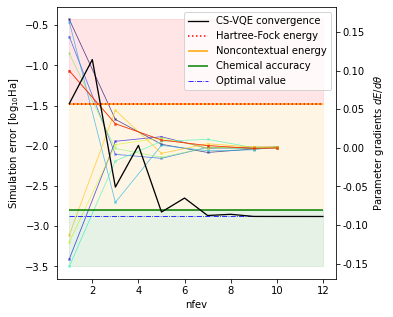

In [14]:
from matplotlib.ticker import FormatStrFormatter

fig,axis = plt.subplots(figsize = (5,5))#, sharex=True, gridspec_kw={'height_ratios': [2, 1]})
#fig.tight_layout()

def transform(dataset, ref_val=0):
    return np.log10(abs(dataset-ref_val))

truegs = model.fci_energy
target = transform(opt_out['fun'], truegs)

X, Y = zip(*interim['values'])
X = np.array(X)
Y = np.array(Y)
Y_error = transform(Y, truegs)
Y_max = np.max(Y_error)+0.5

nfev      = X[-1]
noncon    = transform(model.noncontextual_energy, truegs)
hf_energy = transform(model.hf_energy, truegs)
chemacc   = transform(0.0016)
axis.plot(X, Y_error, label='CS-VQE convergence', color='black', zorder=4, lw=1.3)

axis.hlines(hf_energy, 1, nfev, color='red',ls=':',label='Hartree-Fock energy', zorder=3)
axis.hlines(noncon, 1, nfev, color='orange', label='Noncontextual energy', zorder=2)
axis.hlines(chemacc, 1, nfev, color='green', label='Chemical accuracy', zorder=2)
axis.hlines(target, 1, nfev, color='blue', label='Optimal value', ls='-.', lw=0.8, zorder=3)

axis.fill_between(X, -3.5,np.log10(0.0016), color='green', alpha=0.1, zorder=1)
axis.fill_between(X, np.log10(0.0016), np.log10(model.noncontextual_energy- truegs), color='orange', alpha=0.1, zorder=1)
axis.fill_between(X, np.log10(model.noncontextual_energy- truegs),Y_max, color='red', alpha=0.1, zorder=1)

axis.set_xlabel('nfev')#, fontname=font)    
axis.set_ylabel('Simulation error [$\mathrm{log}_{10}\mathrm{Ha}$]', fontsize=10)#,fontname = font)
#axis.set_xticks(np.arange(1, X_max, 5))
axis.set_yticks(np.arange(-3.5, Y_max, 0.5))
axis.legend()

axis_grad = axis.twinx()
X_grad, Y_grad_list = zip(*interim['gradients'])
for index, Y_grad in enumerate(zip(*Y_grad_list)):
    Y_grad = np.array(Y_grad)
    c = plt.cm.jet(index/(len(Y_grad_list[0])))
    axis_grad.plot(X_grad, Y_grad, color=c, lw=0.8, alpha=0.7, marker='x', ms=2)

axis_grad.set_ylabel('Parameter gradients $dE/d\\theta$', fontsize=10)#,fontname = font)
axis_grad.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#axis_grad.set_ylim(-1,1)
axis.set_zorder(axis_grad.get_zorder()+1)
axis.set_frame_on(False)
